# Trabalho Final - Álgebra Linear e Aplicações - SME0142

# ATENÇÃO
Necessário ter o OpenGL, glfw e demais bibliotecas instaladas corretamente, além dos arquivos descritivos dos objetos, para rodar o código corretamente.

Link para a apresentação: https://www.youtube.com/watch?v=WGXWaJfE1S4

## Alunos:
> Fabricio Sampaio - NUSP: 12547423

> Vitor Nishimura Vian - NUSP: 5255289

## Explicação Geral: 
O presente trabalho explora a área de Álgebra Linear aplicada a Computação Gráfica, mais especificamente a conhecida biblioteca de renderização **Open GL**. 
Conceitos como vetores, matrizes e transformações lineares são essenciais para a manipulação e renderização de objetos em ambientes virtuais, sejam eles 2D ou 3D.

Vetores são utilizados para representar pontos, direções e normais de superfícies, enquanto matrizes são essenciais para aplicar transformações como translações, rotações e escalonamentos, que definem o posicionamento e a orientação de objetos no espaço. Matrizes de projeção, como as projeções perspectiva e ortográfica, convertem coordenadas 3D para 2D, permitindo que cenas tridimensionais sejam renderizadas em telas bidimensionais. 

Assim sendo, a álgebra linear é o núcleo matemático que sustenta a computação gráfica, sendo indispensável para o desenvolvimento de aplicações visuais como jogos, simulações e animações.

## O Trabalho:

O código cria e renderiza em tempo real um ambiente 3D interativo, que se modifica de acordo com os comandos do teclado e do mouse do usuário, como um _**videogame**_. As ferramentes utilizadas para a criar a sensação de movimento na tela do computador, assim como o modelo de iluminação utilizado, são provenientes da Álgebra Linear e serão o foco das explicações teóricas a seguir. Conceitos mais profundos da Ciência da Computação, como a utilização das _GPUs_ e seu processamente paralelo, estruturas de dados e a própria biblioteca Open GL, serão explicados brevemente, mas o foco principal estará na aplicação direta da Álgebra Linear no contexto da computação gráfica.

## Comandos do "_videogame_":
> P: alterna entre visualização padrão e malha poligonal;

### Movimentação da Câmera
> W: Movimenta a câmera para frente;

> A: Movimenta a câmera para esquerda;

> S: Movimenta a câmera para trás;

> D: Movimenta a câmera para direita;

> Mouse: Muda a direção da câmera de acordo com o movimento.

## Controles de Iluminação:
> L: Liga/Desliga a luz da câmera (lanterna);

> 1 e 2: Diminui e aumenta a luz ambiente, respectivamente;

> 3 e 4: Diminui e aumenta a reflexão difusa, respectivamente;

> 5 e 6: Diminui e aumenta a reflexão especular, respectivamente.

## Transformações do Objeto "_Shrek_":
Do lado exterior do mundo 3D criado, existe um objeto representando o famoso personagem animado _Shrek_. Nele, todas as transformações ocorrem:
> Rotação: o objeto está constantemente sendo rotacionado;

> Translação: controlada pelas setas do teclado (→, ←, ↑ e ↓);

> Escala: '>' para aumentar de tamanho de forma uniforme e '<' para diminuir de tamanho de forma uniforme.

# Importações de bibliotecas

In [1]:
import glfw
from OpenGL.GL import *
import OpenGL.GL.shaders
import numpy as np
import math
from PIL import Image

# Definição da classe MatrizTRS

In [2]:
# Classe que guarda a matriz translação de cada objeto
class MatrizTRS:

    def __init__(self):
        self.t = [0.0, 0.0, 0.0]
        self.r = [0.0, 1.0, 0.0]
        self.s = [1.0, 1.0, 1.0]
    
    def change_T(self, t):
        self.t = t
    
    def change_R(self, r):
        self.r = r
    
    def change_S(self, s):
        self.s = s

    def change_All(self, t, r, s):
        self.t = t
        self.r = r
        self.s = s

# Funções para substituição de glm usando numpy
def vec3(x, y, z):
    return np.array([x, y, z], dtype=np.float32)

def mat4_identity():
    return np.eye(4, dtype=np.float32)

def translate(matrix, vector):
    translation = np.eye(4, dtype=np.float32)
    translation[:3, 3] = vector[:3]  # Garante que apenas os primeiros 3 componentes sejam usados
    return np.dot(matrix, translation)

def scale(matrix, vector):
    scaling = np.eye(4, dtype=np.float32)
    scaling[0, 0], scaling[1, 1], scaling[2, 2] = vector
    return np.dot(matrix, scaling)

def rotate(matrix, angle, axis):
    angle = np.radians(angle)
    axis = axis / np.linalg.norm(axis)
    c, s = np.cos(angle), np.sin(angle)
    x, y, z = axis
    rotation = np.array([
        [c + (1-c)*x*x, (1-c)*x*y - s*z, (1-c)*x*z + s*y, 0],
        [(1-c)*y*x + s*z, c + (1-c)*y*y, (1-c)*y*z - s*x, 0],
        [(1-c)*z*x - s*y, (1-c)*z*y + s*x, c + (1-c)*z*z, 0],
        [0, 0, 0, 1]
    ], dtype=np.float32)
    return np.dot(matrix, rotation)

def lookAt(eye, center, up):
    f = center - eye
    f = f / np.linalg.norm(f)

    u = up / np.linalg.norm(up)
    s = np.cross(f, u)
    u = np.cross(s, f)

    result = np.eye(4, dtype=np.float32)
    result[0, :3] = s
    result[1, :3] = u
    result[2, :3] = -f
    result[:3, 3] = -np.dot(result[:3, :3], eye)

    return result

def perspective(fovy, aspect, near, far):
    fovy_rad = np.radians(fovy)
    f = 1 / np.tan(fovy_rad / 2)
    result = np.zeros((4, 4), dtype=np.float32)
    result[0, 0] = f / aspect
    result[1, 1] = f
    result[2, 2] = (far + near) / (near - far)
    result[2, 3] = (2 * far * near) / (near - far)
    result[3, 2] = -1
    return result

# Definição da Classe Object

A classe definida abaixo é utilizada para definir todos os objetos renderizados em cena. As árvores, personagens, casas e até o chão são instâncias dessa mesma classe.

Ela armazena informações como: informações para renderização do modelo, arquivo de textura, coeficientes de iluminação do material que deseja representar (mais sobre iluminção mais a frente do programa)

In [3]:
class Material:
    def __init__(self, name, ka, kd, ks, ns):
        self.name = name
        self.ka = ka
        self.kd = kd
        self.ks = ks
        self.ns = ns

class Object:
    def __init__(self, url_model, urls_textures, start_id_texture, material, is_inside=False):
        modelo = load_model_from_file(url_model)
        print('Processando modelo: ' + url_model)
        textures_verts = processando_modelo(modelo)
        for i in range(len(urls_textures)):
            load_texture_from_file(start_id_texture + i, urls_textures[i])
        self.matriz = MatrizTRS()
        self.angle = 0
        self.textures_verts = textures_verts
        self.start_id_texture = start_id_texture
        self.is_inside = is_inside
        self.material = material

    def change_angle(self, angle):
        self.angle = angle

    def desenha(self, model, program):
        mat_model = model(self.angle, self.matriz)
        loc_model = glGetUniformLocation(program, "model")
        glUniformMatrix4fv(loc_model, 1, GL_TRUE, mat_model)

        loc_ka = glGetUniformLocation(program, "ka")
        glUniform1f(loc_ka, self.material.ka)

        loc_kd = glGetUniformLocation(program, "kd")
        glUniform1f(loc_kd, self.material.kd)

        loc_ks = glGetUniformLocation(program, "ks")
        glUniform1f(loc_ks, self.material.ks)

        loc_ns = glGetUniformLocation(program, "ns")
        glUniform1f(loc_ns, self.material.ns)

        loc_is_inside = glGetUniformLocation(program, "is_inside")
        glUniform1i(loc_is_inside, self.is_inside)

        for i in range(len(self.textures_verts)-1):
            glBindTexture(GL_TEXTURE_2D, self.start_id_texture + i)
            glDrawArrays(GL_TRIANGLES, self.textures_verts[i], self.textures_verts[i+1] - self.textures_verts[i])

# Listas de vértices e carregando modelo e texturas

In [4]:
### A lista abaixo armazena todos os vertices carregados dos arquivos
vertices_list = []    
textures_coord_list = []
normals_list = []


In [5]:
def load_texture_from_file(texture_id, img_textura):
    glBindTexture(GL_TEXTURE_2D, texture_id)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_WRAP_S, GL_REPEAT)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_WRAP_T, GL_REPEAT)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_LINEAR)
    glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_LINEAR)
    img = Image.open(img_textura)
    img_width, img_height = img.size
    image_data = img.convert("RGBA").tobytes("raw", "RGBA", 0, -1)
    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGBA, img_width, img_height, 0, GL_RGBA, GL_UNSIGNED_BYTE, image_data)


In [6]:
def load_model_from_file(filename):
    objects = {}
    vertices = []
    normals = []
    texture_coords = []
    faces = []

    material = None

    for line in open(filename, "r"):
        if line.startswith('#'):
            continue
        values = line.split()
        if not values:
            continue

        if values[0] == 'v':
            vertices.append(values[1:4])
        if values[0] == 'vn':
            normals.append(values[1:4])
        elif values[0] == 'vt':
            texture_coords.append(values[1:3])
        elif values[0] in ('usemtl', 'usemat'):
            material = values[1]
        elif values[0] == 'f':
            face = []
            face_texture = []
            face_normals = []
            for v in values[1:]:
                w = v.split('/')
                face.append(int(w[0]))
                face_normals.append(int(w[2]))
                if len(w) >= 2 and len(w[1]) > 0:
                    face_texture.append(int(w[1]))
                else:
                    face_texture.append(0)
            faces.append((face, face_texture, face_normals, material))

    model = {
        'vertices': vertices,
        'texture': texture_coords,
        'faces': faces,
        'normals': normals
    }

    return model

Explicar Arquivo wave front rapidamente 

In [7]:
def processando_modelo(modelo):
    global vertices_list, textures_coord_list, normals_list
    textures_verts = []
    faces_visited = []
    for face in modelo['faces']:
        if face[3] not in faces_visited:
            faces_visited.append(face[3])
            textures_verts.append(len(vertices_list))
        for vertice_id in face[0]:
            vertices_list.append(modelo['vertices'][vertice_id-1])
        for texture_id in face[1]:
            textures_coord_list.append(modelo['texture'][texture_id-1])
        for normal_id in face[2]:
            normals_list.append(modelo['normals'][normal_id-1])

    textures_verts.append(len(vertices_list))
    return textures_verts

# Funções de controle e interação com o ambiente virtual em 3D

Nessa seção são definidos os controles descritos no início desse Notebook, como movimentação, direção da câmera e uma forma simples de definir as fronteiras do mundo criado (_clamp_).

In [8]:
qtd_texturas = 25
altura = 1600
largura = 1900

min_x, max_x = -80, 80
min_y, max_y = 5,50
min_z, max_z = -80,80

lantern_on = True

inc_amb = inc_spec = inc_dif = 0.6

# Função que não permite o usuário passar do extremos no mapa 
def clamp(value, min_value, max_value):
    return max(min_value, min(max_value, value))

def normalize(vector):
    return vector / np.linalg.norm(vector)

## Eventos para modificar a posição da câmera.
# * Usei as teclas A, S, D e W para movimentação no espaço tridimensional
# * Usei a posição do mouse para "direcionar" a câmera
def key_event(window,key,scancode,action,mods):
    global cameraPos, cameraFront, cameraUp, polygonal_mode, inc_fov, inc_near, inc_far, cameraUp, inc_view_up, lantern_on, inc_amb, inc_dif, inc_spec

    if key == 66:
        inc_view_up += 0.1
        #cameraUp    = glm.vec3(0.0+inc_view_up,  1.0+inc_view_up,  0.0+inc_view_up);
    if key == 78: inc_near += 0.1
    if key == 77: inc_far -= 5
        
    
        
    cameraSpeed = 1
    if key == 87 and (action==1 or action==2): # tecla W
        cameraPos += cameraSpeed * cameraFront
    
    if key == 83 and (action==1 or action==2): # tecla S
        cameraPos -= cameraSpeed * cameraFront
    
    if key == 65 and (action==1 or action==2): # tecla A
        cameraPos -= normalize(np.cross(cameraFront, cameraUp)) * cameraSpeed
        
    if key == 68 and (action==1 or action==2): # tecla D
        cameraPos += normalize(np.cross(cameraFront, cameraUp)) * cameraSpeed

    cameraPos[0] = clamp(cameraPos[0], min_x, max_x)  # x -> índice 0
    cameraPos[1] = clamp(cameraPos[1], min_y, max_y)  # y -> índice 1
    cameraPos[2] = clamp(cameraPos[2], min_z, max_z)  # z -> índice 2


    if key == 265 and (action==1 or action==2): # tecla seta cima
        shrek.matriz.change_T([shrek.matriz.t[0], shrek.matriz.t[1], shrek.matriz.t[2] - 0.1])

    if key == 264 and (action==1 or action==2): # tecla seta baixo
        shrek.matriz.change_T([shrek.matriz.t[0], shrek.matriz.t[1], shrek.matriz.t[2] + 0.1])

    if key == 262 and (action==1 or action==2): # tecla seta direita
        shrek.matriz.change_T([shrek.matriz.t[0] + 0.1, shrek.matriz.t[1], shrek.matriz.t[2]])

    if key == 263 and (action==1 or action==2): # tecla seta esquerda
        shrek.matriz.change_T([shrek.matriz.t[0] - 0.1, shrek.matriz.t[1], shrek.matriz.t[2]])

    if key == 46 and (action==1 or action==2): # tecla "." ">"
        shrek.matriz.change_S([shrek.matriz.s[0] + 0.001, shrek.matriz.s[1] + 0.001, shrek.matriz.s[2] + 0.001])
        
    if key == 44 and (action==1 or action==2): # tecla "," "<"
        shrek.matriz.change_S([shrek.matriz.s[0] - 0.001, shrek.matriz.s[1] - 0.001, shrek.matriz.s[2] - 0.001])

    if key == 80 and action == 1: polygonal_mode = not polygonal_mode

    #Tecla L, alternar lanterna ligada ou desligada
    if key == 76 and action == 1: lantern_on = not lantern_on

    # tecla 1 diminui iluminação ambiental e 2 aumenta
    if key == 49 and (action == 1 or action == 2) : inc_amb -=0.1
    if key == 50 and (action == 1 or action == 2) : inc_amb +=0.1

    # tecla 3 diminui iluminação difusa e 4 aumenta
    if key == 51 and (action == 1 or action == 2) : inc_dif -=0.1
    if key == 52 and (action == 1 or action == 2) : inc_dif +=0.1

    # tecla 5 diminui iluminação ambiental e 6 aumenta
    if key == 53 and (action == 1 or action == 2) : inc_spec -=0.1
    if key == 54 and (action == 1 or action == 2) : inc_spec +=0.1

    inc_amb = clamp(inc_amb, 0.0, 50)
    inc_dif = clamp(inc_dif, 0.0, 50)
    inc_spec = clamp(inc_spec, 0.0, 50)



def mouse_event(window, xpos, ypos):
    global firstMouse, cameraFront, yaw, pitch, lastX, lastY
    if firstMouse:
        lastX = xpos
        lastY = ypos
        firstMouse = False

    xoffset = xpos - lastX
    yoffset = lastY - ypos
    lastX = xpos
    lastY = ypos

    sensitivity = 0.3 
    xoffset *= sensitivity
    yoffset *= sensitivity

    yaw += xoffset;
    pitch += yoffset;




    pitch = clamp(pitch, -60.0, 60.0)  # Limitar o pitch
    front = np.array([
        math.cos(math.radians(yaw)) * math.cos(math.radians(pitch)),
        math.sin(math.radians(pitch)),
        math.sin(math.radians(yaw)) * math.cos(math.radians(pitch))
    ], dtype=np.float32)
    cameraFront = normalize(front)

# Pipeline gráfico

In [9]:
### Matrizes Model, View e Projection
def model(angle, matriz):
    
    matrix_transform = mat4_identity()
    matrix_transform = translate(matrix_transform, matriz.t)
    matrix_transform = rotate(matrix_transform, angle, matriz.r)
    matrix_transform = scale(matrix_transform, matriz.s)
    
    return matrix_transform

def view():
    return lookAt(cameraPos, cameraPos + normalize(cameraFront), cameraUp)


def projection():
    global altura, largura, inc_fov, inc_near, inc_far
    # perspective parameters: fovy, aspect, near, far
    return perspective(45.0, largura / altura, 0.1, 1000.0)

### Inicializando janela
glfw.init()
glfw.window_hint(glfw.VISIBLE, glfw.FALSE);
window = glfw.create_window(largura, altura, "Malhas e Texturas", None, None)
glfw.make_context_current(window)

explicar matriz model, projection e view 
também os espacos (mundo, clip, etc)
explicar o near, fov, aspect e far e aquele sólido 3d (frustum)

# Vertex Code


In [10]:
vertex_code = """

        #version 330 core

        attribute vec3 position;
        attribute vec2 texture_coord;
        attribute vec3 normals;

        varying vec2 out_texture;
        varying vec3 out_fragPos;
        varying vec3 out_normal;

        uniform mat4 model;
        uniform mat4 view;
        uniform mat4 projection;

        void main(){
            gl_Position = projection * view * model * vec4(position,1.0);
            out_texture = texture_coord;
            out_fragPos = vec3(model * vec4(position, 1.0));
            out_normal = mat3(transpose(inverse(model))) * normals;
        }
        """

explicar vertex code

# Fragment Code e Modelo de Iluminação de Phong

In [11]:
fragment_code = """

        #version 330 core
        uniform bool lantern_on;

        uniform vec3 lightPos1;
        vec3 lightColor1 = vec3(1.0, 1.0, 1.0);

        uniform vec3 lightPos2;
        uniform vec3 lightColor2;

        uniform vec3 lightPos3;
        vec3 lightColor3 = vec3(1.0, 1.0, 0.7);


        uniform float ka;
        uniform float kd;
        uniform float ks;
        uniform float ns;

        uniform float inc_amb;
        uniform float inc_spec;
        uniform float inc_dif;

        uniform vec3 viewPos;

        varying vec2 out_texture;
        varying vec3 out_normal;
        varying vec3 out_fragPos;
        uniform sampler2D samplerTexture;

        uniform bool is_inside;

        void main(){

        vec3 interior_amb = ka * lightColor3 * inc_amb;
        vec3 exterior_amb = ka * lightColor1 * inc_amb;

            // LUZ 1 - LUZ DO PERSONAGEM (LANTERNA)
            vec3 lightDir = lightPos1 - out_fragPos;
            float lightDistance = length(lightDir);

            lightDir = lightDir / lightDistance;
            vec3 norm = normalize(out_normal);
            vec3 viewDir = normalize(viewPos - out_fragPos);
            float attenuation = 1.0 / (0.005 * (lightDistance * lightDistance));

            float diff = max(dot(norm, lightDir), 0.0);
            vec3 diffuse1 = kd * diff * lightColor1 * attenuation * (lantern_on ? 1.0 : 0.0) * inc_dif;

            vec3 reflectDir = normalize(reflect(-lightDir, norm));
            float spec = pow(max(dot(viewDir, reflectDir), 0.0), ns);
            vec3 specular1 = ks * spec * lightColor1 * attenuation * (lantern_on ? 1.0 : 0.0) * inc_spec;

            // LUZ 2 - LUZ DA POLICIA (GIROFLEX)
            lightDir = lightPos2 - out_fragPos;
            lightDistance = length(lightDir);

            lightDir = lightDir / lightDistance;
            viewDir = normalize(viewPos - out_fragPos);
            attenuation = 1.0 / (0.0025 * (lightDistance * lightDistance));

            diff = max(dot(norm, lightDir), 0.0);
            vec3 diffuse2 = 0.5 * diff * lightColor2 * attenuation * inc_dif;

            reflectDir = normalize(reflect(-lightDir, norm));
            spec = pow(max(dot(viewDir, reflectDir), 0.0), ns);
            vec3 specular2 = 0.01 * spec * lightColor2 * attenuation * inc_spec;


            // LUZ 3 - LUZ INTERNA
            lightDir = (lightPos3 - out_fragPos);
            lightDistance = length(lightDir);

            lightDir = lightDir / lightDistance;
            viewDir = normalize(viewPos - out_fragPos);
            attenuation = 1.0 / (0.0025 * (lightDistance * lightDistance));

            diff = max(dot(norm, lightDir), 0.0);
            vec3 diffuse3 = kd * diff * lightColor3 * attenuation * inc_dif;

            reflectDir = normalize(reflect(-lightDir, norm));
            spec = pow(max(dot(viewDir, reflectDir), 0.0), ns);
            vec3 specular3 = 0.01 * spec * lightColor3 * attenuation * inc_spec;

            // ADICIONANDO AS LUZES NOS OBJETOS
            vec4 texture = texture2D(samplerTexture, out_texture);
            vec3 lighting1 = diffuse1 + specular1;
            vec3 lighting2 = diffuse2 + specular2;
            vec3 lighting3 = diffuse3 + specular3;

            vec3 lighting;
            if(!is_inside){
                lighting = lighting1 + lighting2 + exterior_amb;
            }else{
                lighting = lighting1 + lighting3 + interior_amb;
            }
            vec4 result = vec4(lighting,1.0) * texture;
            gl_FragColor = result;
        }
        """


In [12]:
### Requisitando slot para a GPU para nossos programas Vertex e Fragment Shaders
# Request a program and shader slots from GPU
program  = glCreateProgram()
vertex   = glCreateShader(GL_VERTEX_SHADER)
fragment = glCreateShader(GL_FRAGMENT_SHADER)



### Associando nosso código-fonte aos slots solicitados
# Set shaders source
glShaderSource(vertex, vertex_code)
glShaderSource(fragment, fragment_code)




### Compilando o Vertex Shader
# Se há algum erro em nosso programa Vertex Shader, nosso app para por aqui.
# Compile shaders
glCompileShader(vertex)
if not glGetShaderiv(vertex, GL_COMPILE_STATUS):
    error = glGetShaderInfoLog(vertex).decode()
    print(error)
    raise RuntimeError("Erro de compilacao do Vertex Shader")



### Compilando o Fragment Shader
# Se há algum erro em nosso programa Fragment Shader, nosso app para por aqui.
glCompileShader(fragment)
if not glGetShaderiv(fragment, GL_COMPILE_STATUS):
    error = glGetShaderInfoLog(fragment).decode()
    print(error)
    raise RuntimeError("Erro de compilacao do Fragment Shader")



### Associando os programas compilado ao programa principal
# Attach shader objects to the program
glAttachShader(program, vertex)
glAttachShader(program, fragment)



### Linkagem do programa
# Build program
glLinkProgram(program)
if not glGetProgramiv(program, GL_LINK_STATUS):
    print(glGetProgramInfoLog(program))
    raise RuntimeError('Linking error')
    


# Make program the default program
glUseProgram(program)



### Preparando dados para enviar a GPU
# Nesse momento, nós compilamos nossos Vertex e Program Shaders para que a GPU possa processá-los.
# Por outro lado, as informações de vértices geralmente estão na CPU e devem ser transmitidas para a GPU.
glHint(GL_LINE_SMOOTH_HINT, GL_DONT_CARE)
glEnable( GL_BLEND )
glBlendFunc( GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA )
glEnable(GL_LINE_SMOOTH)
glEnable(GL_TEXTURE_2D)
textures = glGenTextures(qtd_texturas)

In [13]:
#Definindo materiais
madeira = Material("madeira", 0.1, 0.6, 0.05, 15)
metal = Material("metal", 0.05, 0.3, 0.9, 200)
tecido = Material("tecido", 0.15, 0.7, 0.1, 10)
pedra = Material("pedra", 0.2, 0.6, 0.1, 15)
pele = Material("pele", 0.15, 0.7, 0.3, 50)
ceu = Material("céu", 0.5, 0.001, 0.001, 10)
grama = Material("grama", 0.25, 0.7, 0.15, 20)

### Vamos carregar cada modelo e sua(s) respectiva(s) textura(s)
terreno_pedra = Object('../objects/terreno/terreno.obj', ['../objects/terreno/caminho_tijolo.jpg'], 0, pedra)
terreno_interno = Object('../objects/terreno/terreno.obj', ['../objects/terreno/pedra.jpg'], 30,pedra, True)
house1 = Object('../objects/casa/casa1.obj', ['../objects/casa/casa.jpg'], 1, madeira)
house_interior = Object('../objects/casa/casa_interior.obj', ['../objects/casa/casa.jpg'], 1, madeira, True)
spiderman = Object('../objects/spiderman/spiderman.obj', ['../objects/spiderman/spiderman.png'],2, tecido)
arvore = Object('../objects/arvore/arvore.obj', ['../objects/arvore/bark_0021.jpg', '../objects/arvore/DB2X2_L01.png'], 3, madeira)
chair = Object('../objects/chair/chair_01.obj', ['../objects/chair/Textures/chair_01_Base_Color.png'], 6, madeira, True)
yoshi = Object('../objects/yoshi/Yoshi(Super Mario Maker).obj', ['../objects/yoshi/SMMYoshi.png'], 7, pele, True)
house2 = Object('../objects/squidward/MSH_SquidwardHouse.obj', ['../objects/squidward/TEX_SquidwardHouse.png'], 8, pedra)
bed = Object('../objects/SpongeBobBed/MSH_boss3.obj', ['../objects/SpongeBobBed/TEX_boss3_barrel.png', '../objects/SpongeBobBed/TEX_boss3_bed.png', '../objects/SpongeBobBed/TEX_boss3_bob.png'], 9,tecido, True)
sky = Object('../objects/sky/275out.obj', ['../objects/sky/275_lp_di1mt55p.png', '../objects/sky/275_di1mt81p.png'], 12, ceu)
field = Object('../objects/field/field1.obj'    , ['../objects/field/76BACB49_c.png', '../objects/field/35BF7BB8_c.png', '../objects/field/32F6789_c.png'], 14, grama)
car = Object('../objects/PoliceCar/policecar.obj', ['../objects/PoliceCar/Tex_0017_0.png'], 17, metal)
shrek = Object('../objects/Shrek/shrek1.obj', ['../objects/Shrek/s1.png', '../objects/Shrek/s2.png'], 18, tecido)
television = Object('../objects/television/a_prop_TV1.obj', ['../objects/television/prop_TV_Lib.tga.png'], 20,metal, True)
rocket = Object('../objects/Rocket/obj0.obj', ['../objects/Rocket/0.png'], 21, metal)
star = Object('../objects/star/star.obj', ['../objects/star/star.png'], 23, metal, True)

Processando modelo: ../objects/terreno/terreno.obj
Processando modelo: ../objects/terreno/terreno.obj
Processando modelo: ../objects/casa/casa1.obj
Processando modelo: ../objects/casa/casa_interior.obj
Processando modelo: ../objects/spiderman/spiderman.obj
Processando modelo: ../objects/arvore/arvore.obj
Processando modelo: ../objects/chair/chair_01.obj
Processando modelo: ../objects/yoshi/Yoshi(Super Mario Maker).obj
Processando modelo: ../objects/squidward/MSH_SquidwardHouse.obj
Processando modelo: ../objects/SpongeBobBed/MSH_boss3.obj
Processando modelo: ../objects/sky/275out.obj
Processando modelo: ../objects/field/field1.obj
Processando modelo: ../objects/PoliceCar/policecar.obj
Processando modelo: ../objects/Shrek/shrek1.obj
Processando modelo: ../objects/television/a_prop_TV1.obj
Processando modelo: ../objects/Rocket/obj0.obj
Processando modelo: ../objects/star/star.obj


Explicar materiais, relacionando com modelo de phong explicado anteriormente

In [14]:
### Para enviar nossos dados da CPU para a GPU, precisamos requisitar slots.
# Nós agora vamos requisitar tres slots.
# Um para enviar coordenadas dos vértices.
# Um para enviar coordenadas de texturas.
# Um para enviar coordenadas de normals para iluminacao.
buffer = glGenBuffers(3)



###  Enviando coordenadas de vértices para a GPU
vertices = np.zeros(len(vertices_list), [("position", np.float32, 3)])
vertices['position'] = vertices_list
glBindBuffer(GL_ARRAY_BUFFER, buffer[0])
glBufferData(GL_ARRAY_BUFFER, vertices.nbytes, vertices, GL_STATIC_DRAW)
stride = vertices.strides[0]
offset = ctypes.c_void_p(0)
loc_vertices = glGetAttribLocation(program, "position")
glEnableVertexAttribArray(loc_vertices)
glVertexAttribPointer(loc_vertices, 3, GL_FLOAT, False, stride, offset)



###  Enviando coordenadas de textura para a GPU
textures = np.zeros(len(textures_coord_list), [("position", np.float32, 2)]) # duas coordenadas
textures['position'] = textures_coord_list
glBindBuffer(GL_ARRAY_BUFFER, buffer[1])
glBufferData(GL_ARRAY_BUFFER, textures.nbytes, textures, GL_STATIC_DRAW)
stride = textures.strides[0]
offset = ctypes.c_void_p(0)
loc_texture_coord = glGetAttribLocation(program, "texture_coord")
glEnableVertexAttribArray(loc_texture_coord)
glVertexAttribPointer(loc_texture_coord, 2, GL_FLOAT, False, stride, offset)



###  Enviando coordenadas da normal para a GPU
normals = np.zeros(len(normals_list), [("position", np.float32, 3)]) # três coordenadas
normals['position'] = normals_list
glBindBuffer(GL_ARRAY_BUFFER, buffer[2])
glBufferData(GL_ARRAY_BUFFER, normals.nbytes, normals, GL_STATIC_DRAW)
stride = normals.strides[0]
offset = ctypes.c_void_p(0)
loc_normals_coord = glGetAttribLocation(program, "normals")
glEnableVertexAttribArray(loc_normals_coord)
glVertexAttribPointer(loc_normals_coord, 3, GL_FLOAT, False, stride, offset)



In [15]:
### Eventos para modificar a posição da câmera.
# * Usei as teclas A, S, D e W para movimentação no espaço tridimensional
# * Usei a posição do mouse para "direcionar" a câmera

cameraPos = np.array([-30.0, 5.0, 30.0], dtype=np.float32)
cameraFront = np.array([0.0, 0.0, -1.0], dtype=np.float32)
cameraUp = np.array([0.0, 1.0, 0.0], dtype=np.float32)

polygonal_mode = False

inc_fov = 0
inc_near = 0
inc_far = 0
inc_view_up = 0
        
firstMouse = True
yaw = -90.0 
pitch = 0.0
lastX =  largura/2
lastY =  altura/2
    
glfw.set_key_callback(window,key_event)
glfw.set_cursor_pos_callback(window, mouse_event)



### Nesse momento, nós exibimos a janela!
glfw.show_window(window)
glfw.set_cursor_pos(window, lastX, lastY)



### Loop principal da janela.
# Enquanto a janela não for fechada, esse laço será executado. É neste espaço que trabalhamos com algumas interações com a OpenGL.
glEnable(GL_DEPTH_TEST) ### importante para 3D


In [16]:
### Setando matrizes iniciais
inc = 0
terreno_pedra.matriz.change_All(
                [0.0, -0.9, -100,0], 
                [0.0, 0.0, 1.0], 
                [2.0, 0.1, 45.0])

field.matriz.change_All(
                [4.0, -1.0, 0,0], 
                [0.0, 0.0, 1.0], 
                [20.0, 20.0, 20.0])

sky.matriz.change_All(
                [0.0, -10.0, 0,0], 
                [1.0, 0.0, 0.0], 
                [5.0, 5.0, 5.0])
sky.change_angle(-90)

spiderman.matriz.change_All(
                [-5.0, -0.9, 30.0],
                [0.0, 1.0, 0.0], 
                [1.0, 1.0, 1.0])
spiderman.change_angle(90)

arvore.matriz.change_All(
                [-10.0, -1.0, 0.0],
                [0.0, 0.0, 1.0], 
                [7.0, 7.0, 7.0])

### CASA E A PARTE INTERNA

house1.matriz.change_All(
                [-30.0, -1.0, 30.0], 
                [0.0, 1.0, 0.0],
                [1.0, 1.0, 1.0])
house1.change_angle(176)

star.matriz.change_All(
                [-30.0, 8.0, 30.0], 
                [0.0, 1.0, 0.0],
                [0.1, 0.1, 0.1])
star.change_angle(86)

house_interior.matriz.change_All(
                [-30.0, -0.98, 30.0], 
                [0.0, 1.0, 0.0],
                [0.99, 0.99, 0.99])
house_interior.change_angle(176)


terreno_interno.matriz.change_All(
                [-28.0, -0.9, 30.0], 
                [0.0, 1.0, 0.0], 
                [5.0, 0.1, 1.9])

chair.matriz.change_All(
                [-30.0, -1.0, 24.0], 
                [0.0, 1.0, 0.0], 
                [4.8, 5.0, 5.0])

bed.matriz.change_All(
                [-38.0, -1.0, 31.5], 
                [0.0, 1.0, 0.0], 
                [1.5, 1.5, 1.5])
bed.change_angle(90)

yoshi.matriz.change_All(
                [-25.0, -1.0, 35.0],
                [0.0, 1.0, 0.0], 
                [3.0, 3.0, 3.0])
yoshi.change_angle(135)

television.matriz.change_All(
                [-15.0, -1.0, 24.0], 
                [0.0, 1.0, 0.0], 
                [0.03, 0.03, 0.03])
television.change_angle(-45)

##################################################

car.matriz.change_All(
                [0.0, -1.0, -60.0],
                [0.0, 1.0, 0.0],
                [0.3, 0.3, 0.3])

house2.matriz.change_All(
                [15.0, -1.0, -10.0], 
                [0.0, 1.0, 0.0], 
                [1.0, 1.0, 1.0])
house2.change_angle(-90)

shrek.matriz.change_All(
                [20.0, -1.0, 20.0], 
                [0.0, 1.0, 0.0], 
                [0.2, 0.2, 0.2])

rocket.matriz.change_All(
                [75.0, 20.0, -50.0], 
                [0.0, 1.0, 0.0], 
                [0.005, 0.005, 0.005])
rocket.change_angle(180)

# Loop Principal do Programa

In [17]:
color_cnt = 0
color_change = False

while not glfw.window_should_close(window):

    inc += 0.05
    color_cnt += 1

    car.matriz.change_T([0.0, -1.0, (-100.0+inc/2)])
    rocket.matriz.change_T([75.0, 20.0, (50.0-inc/3)])
    shrek.change_angle(inc*20)

    glfw.poll_events() 
    
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    glClearColor(1.0, 1.0, 1.0, 1.0)

    # Atualiza estado da lanterna
    loc_lantern_on = glGetUniformLocation(program, "lantern_on")
    glUniform1i(loc_lantern_on, int(lantern_on))

    # Atualiza estado dos inc das iluminações

    loc_inc_amb = glGetUniformLocation(program, "inc_amb")
    glUniform1f(loc_inc_amb, inc_amb)

    loc_inc_dif = glGetUniformLocation(program, "inc_dif")
    glUniform1f(loc_inc_dif, inc_dif)

    loc_inc_spec = glGetUniformLocation(program, "inc_spec")
    glUniform1f(loc_inc_spec, inc_spec)





    
    if polygonal_mode: glPolygonMode(GL_FRONT_AND_BACK,GL_LINE)
    if not polygonal_mode: glPolygonMode(GL_FRONT_AND_BACK,GL_FILL)
    
    field.desenha(model, program)
    sky.desenha(model, program)
    terreno_pedra.desenha(model, program)

    house1.desenha(model, program)
    star.desenha(model, program)
    house_interior.desenha(model,program)
    terreno_interno.desenha(model, program)
    chair.desenha(model, program)
    bed.desenha(model, program)
    
    yoshi.desenha(model, program)
    television.desenha(model,program)

    spiderman.desenha(model, program)   
    house2.desenha(model, program)
    car.desenha(model, program)
    shrek.desenha(model, program)
    rocket.desenha(model, program)

    for i in range(5):        
        arvore.matriz.change_T([arvore.matriz.t[0], arvore.matriz.t[1], i*20])
        arvore.desenha(model, program)
        arvore.matriz.change_T([arvore.matriz.t[0], arvore.matriz.t[1], i*(-20)])
        arvore.desenha(model, program)

    loc_light_pos1 = glGetUniformLocation(program, "lightPos1")
    glUniform3f(loc_light_pos1, cameraPos[0], cameraPos[1], cameraPos[2])

    loc_light_pos2 = glGetUniformLocation(program, "lightPos2")
    glUniform3f(loc_light_pos2, car.matriz.t[0], car.matriz.t[1], car.matriz.t[2])

    loc_light_pos3 = glGetUniformLocation(program, "lightPos3")
    glUniform3f(loc_light_pos3,star.matriz.t[0], star.matriz.t[1], star.matriz.t[2])

    if color_cnt % 50 == 0: color_change = not color_change

    loc_light_color2 = glGetUniformLocation(program, "lightColor2")
    if color_change: glUniform3f(loc_light_color2, 1.0, 0.0, 0.0)
    else: glUniform3f(loc_light_color2, 0.0, 0.0, 1.0)

    mat_view = view()
    loc_view = glGetUniformLocation(program, "view")
    glUniformMatrix4fv(loc_view, 1, GL_TRUE, mat_view)

    mat_projection = projection()
    loc_projection = glGetUniformLocation(program, "projection")
    glUniformMatrix4fv(loc_projection, 1, GL_TRUE, mat_projection)    
    
    loc_view_pos = glGetUniformLocation(program, "viewPos")
    glUniform3f(loc_view_pos, cameraPos[0], cameraPos[1], cameraPos[2])

    glfw.swap_buffers(window)

glfw.terminate()

# Transformações



## Translação

A translação desloca um objeto de um lugar para outro no espaço, somando um vetor de deslocamento ($T_x$, $T_y$, $T_z$) às coordenadas dos pontos do objeto.

**Matriz de translação:**

$$
\begin{bmatrix}
1 & 0 & 0 & T_x \\
0 & 1 & 0 & T_y \\
0 & 0 & 1 & T_z \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

$T_x$, $T_y$, $T_z$ representam o deslocamento em cada eixo. Em coordenadas homogêneas, a multiplicação dessa matriz por um vetor $v=(x,y,z,1)$ resulta no vetor transladado:

$$
v' = T \cdot v = 
\begin{bmatrix}
1 & 0 & 0 & T_x \\
0 & 1 & 0 & T_y \\
0 & 0 & 1 & T_z \\
0 & 0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
=
\begin{bmatrix}
x + T_x \\
y + T_y \\
z + T_z \\
1
\end{bmatrix}
$$



## Rotação

A rotação move os pontos de um objeto ao longo de um círculo em torno de um eixo (X, Y ou Z). Isso é feito aplicando as funções trigonométricas seno e cosseno.

**Matriz de rotação no eixo Z:**

$$
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 & 0 \\
\sin(\theta) & \cos(\theta) & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

Aqui, $\theta$ é o ângulo de rotação.

Para rotar um ponto $(x, y, z)$ ao redor do eixo Z:

$$
x' = x \cdot \cos(\theta) - y \cdot \sin(\theta) \\
y' = x \cdot \sin(\theta) + y \cdot \cos(\theta)
$$



## Escala

A escala redimensiona um objeto multiplicando suas coordenadas por fatores $S_x$, $S_y$, $S_z$ em cada eixo.

**Matriz de escala:**

$$
\begin{bmatrix}
S_x & 0 & 0 & 0 \\
0 & S_y & 0 & 0 \\
0 & 0 & S_z & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

$S_x$, $S_y$, $S_z$ são os fatores de escala em cada eixo.

Multiplicando por essa matriz:

$$
x' = S_x \cdot x \\
y' = S_y \cdot y \\
z' = S_z \cdot z
$$



## Composição de Transformações

As transformações podem ser combinadas multiplicando suas matrizes na ordem correta, já que multiplicação de matrizes não é comutativa.

Por exemplo, para escalar, depois rotar e transladar:

$$
T_{final} = T_{translation} \cdot T_{rotation} \cdot T_{scale}
$$



## Coordenadas Homogêneas

Coordenadas homogêneas são uma extensão das coordenadas cartesianas usadas em computação gráfica para unificar transformações geométricas, como translação, rotação, escala e projeção, em operações matriciais. No espaço tridimensional, um ponto $(x, y, z)$ é representado como $(x, y, z, w)$, onde $w$ é um fator de escala.

Essas coordenadas permitem representar translações (que não podem ser feitas com matrizes $(3 \times 3)$ como multiplicações de matrizes $(4 \times 4)$, facilitando a composição de transformações em uma única matriz. Além disso, coordenadas homogêneas tornam possíveis projeções em perspectiva, já que objetos distantes podem ser ajustados de acordo com $w$, criando o efeito de profundidade. Também são úteis para representar pontos no infinito $(w=0)$, fundamentais para projeções projetivas e gráficos avançados.



# Pipeline Gráfico 3D

O pipeline gráfico é o processo pelo qual cenas 3D são transformadas em imagens 2D para exibição. Ele envolve várias etapas que manipulam objetos e a câmera no espaço 3D e projetam tudo na tela. Cada etapa pode ser descrita como uma sequência de transformações matemáticas:



## Model Transformation

Move o objeto do espaço local para o espaço global. Utiliza as transformações explicadas acima.

**Exemplo:** Um cubo com vértice em $(1, 1, 1)$ precisa ser deslocado em $(3, 2, 0)$, rotacionado 90º em $Z$ e escalado por fator 2.

**Matriz resultante:**

$$
M = 
\begin{bmatrix}
0 & -2 & 0 & 3 \\
2 & 0 & 0 & 2 \\
0 & 0 & 2 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
, 
v = 
\begin{bmatrix}
1 \\
1 \\
1 \\
1
\end{bmatrix}
$$

$$
v' = M \cdot v = 
\begin{bmatrix}
1 \\
5 \\
2 \\
1
\end{bmatrix}
$$



## View Transformation

Converte o mundo para o espaço da câmera, como se a câmera estivesse na origem olhando para o eixo $-Z$. Envolve translação (posicionar a câmera na origem) e rotação (orientar a visão).

**Exemplo:** A câmera está em $(5, 3, 2)$ e olha para o eixo $-Z$.

**Matriz de translação da câmera:**

$$
T =
\begin{bmatrix}
1 & 0 & 0 & -5 \\
0 & 1 & 0 & -3 \\
0 & 0 & 1 & -2 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

Aplicar em um vértice (10,10,10,1):

$$
v' = T.
\begin{bmatrix}
10 \\
10 \\
10 \\
1
\end{bmatrix}
=
\begin{bmatrix}
5 \\
7 \\
8 \\
1
\end{bmatrix}
$$

O ponto é agora relativo à câmera.



## Projection Transformation

Converte do espaço da câmera para o espaço projetado. Projeção **ortogonal** mantém proporções, enquanto projeção em **perspectiva** cria profundidade visual.

**Projeção em perspectiva:**

$$
P =
\begin{bmatrix}
1/(aspect*tan(fov/2)) & 0 & 0 & 0 \\
0 & 1/tan(fov/2) & 0 & 0 \\
0 & 0 & (f+n)/(f-n) & -2fn/(f-n) \\
0 & 0 & -1 & 0
\end{bmatrix}
$$

aspect, fov: parâmetros da câmera.
n, f: planos próximo e distante.


**Exemplo:** Projetar (5,7,8,1) com n=1, f=10:
$$
v' = P.
\begin{bmatrix}
5 \\
7 \\
8 \\
1
\end{bmatrix}
=
\begin{bmatrix}
5 \\
7 \\
-1.4 \\
-8
\end{bmatrix}
$$


# Modelo de Iluminação de Phong

O **modelo de iluminação de Phong** é amplamente utilizado em computação gráfica para simular como a luz interage com superfícies. Ele baseia-se em três componentes principais: **ambiente**, **difusa** e **especular**.

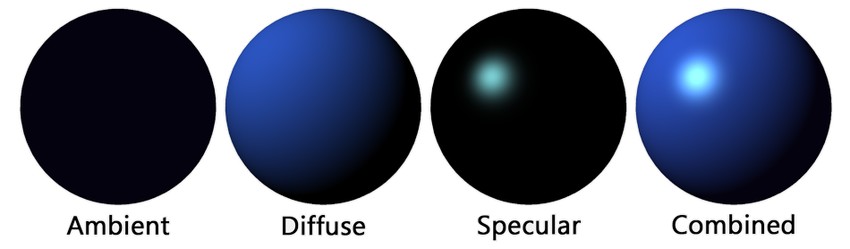

Fonte: https://www.researchgate.net/figure/The-components-of-the-Phong-illumination-model_fig4_370763969
## Componentes do Modelo de Phong

### a) Iluminação Ambiente
A luz ambiente representa a iluminação indireta, uniforme no ambiente, adicionando brilho mínimo à superfície, mesmo em áreas sombreadas.

**Fórmula**:
$$
I_a = k_a \cdot L_a
$$

- $k_a$: coeficiente de reflexão ambiente da superfície.
- $L_a$: intensidade da luz ambiente.



### b) Iluminação Difusa
A iluminação difusa modela a luz que atinge diretamente a superfície e é refletida igualmente em todas as direções, seguindo a **Lei de Lambert**.

**Fórmula**:
$$
I_d = k_d \cdot L_d \cdot \max(0, N \cdot L)
$$

- $k_d$: coeficiente de reflexão difusa da superfície.
- $L_d$: intensidade da luz.
- $N \cdot L$: produto escalar entre os vetores normal ($N$) e de luz ($L$).



### c) Iluminação Especular
A iluminação especular representa os brilhos reflexivos observados em superfícies brilhantes. Esse componente depende do ângulo entre o vetor refletido ($R$) e o vetor da câmera ($V$).

**Fórmula**:
$$
I_s = k_s \cdot L_s \cdot \max(0, R \cdot V)^n
$$

- $k_s$: coeficiente de reflexão especular da superfície.
- $L_s$: intensidade da luz.
- $R \cdot V$: produto escalar entre os vetores refletido ($R$) e da câmera ($V$).
- $n$: expoente de rugosidade (determina o quão "focado" ou "espalhado" é o brilho).

**Cálculo do vetor refletido**:
$$
R = 2 (N \cdot L) N - L
$$

## Fórmula Geral do Modelo de Phong
Combinando os três componentes (ambiente, difusa e especular), a intensidade total da luz em um ponto da superfície é dada por:

$$
I = I_a + I_d + I_s
$$

Onde cada componente ($I_a$, $I_d$ e $I_s$) é calculado para cada fonte de luz.


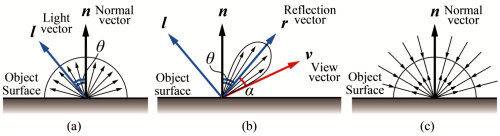

Sendo:
- a) Vetores na reflexão difusa da luz
- b) Vetores na reflexão especular
- c) Vetores na reflexão da luz ambiente

# Exemplo Numérico do Modelo de Phong

### 1. Propriedades do Material
- Coeficiente ambiente: $k_a = 0.5$
- Coeficiente difuso: $k_d = 0.7$
- Coeficiente especular: $k_s = 0.9$
- Rugosidade: $n = 10$

### 2. Propriedades da Luz
- Intensidade ambiente: $L_a = 0.3$
- Intensidade difusa: $L_d = 1.0$
- Intensidade especular: $L_s = 0.8$

### 3. Vetores
- Vetor normal: $N = [0, 0, 1]$
- Vetor luz: $L = [0, 0, 1]$
- Vetor câmera: $V = [0, 0, 1]$

## Cálculos

### 1. Componente Ambiente
$$
I_a = k_a \cdot L_a
$$

Substituindo:
$$
I_a = 0.5 \cdot 0.3 = 0.15
$$

### 2. Componente Difusa
$$
I_d = k_d \cdot L_d \cdot \max(0, N \cdot L)
$$

O produto escalar:
$$
N \cdot L = [0, 0, 1] \cdot [0, 0, 1] = 1
$$

Substituindo:
$$
I_d = 0.7 \cdot 1.0 \cdot 1 = 0.7
$$

### 3. Componente Especular
$$
I_s = k_s \cdot L_s \cdot \max(0, R \cdot V)^n
$$

O vetor refletido:
$$
R = 2 (N \cdot L) N - L
$$

Substituindo:
$$
R = 2 (1) [0, 0, 1] - [0, 0, 1] = [0, 0, 1]
$$

O produto escalar:
$$
R \cdot V = [0, 0, 1] \cdot [0, 0, 1] = 1
$$

Substituindo:
$$
I_s = 0.9 \cdot 0.8 \cdot 1^{10} = 0.72
$$
### 4. Intensidade Total
$$
I = I_a + I_d + I_s
$$

Substituindo:
$$
I = 0.15 + 0.7 + 0.72 = 1.57
$$


# Uso da Intensidade $I$ no Modelo de Phong

O valor $I$ (intensidade total da luz) é usado para ajustar a cor do ponto ou pixel correspondente no modelo 3D, multiplicando-o pelos valores RGB da cor base do material.

Se a cor base do ponto é $C = (R, G, B)$, a cor final é calculada como:

$$
C_{\text{final}} = I \cdot (R, G, B)
$$

### Exemplo Numérico

- Cor base: $C = (R = 0.5, G = 0.3, B = 0.1)$.
- Intensidade: $I = 1.57$.

Substituindo:

$$
C_{\text{final}} = (0.5 \cdot 1.57, 0.3 \cdot 1.57, 0.1 \cdot 1.57)
$$

Resultado:

$$
C_{\text{final}} = (0.785, 0.471, 0.157)
$$

### Clampeamento

Caso os valores de $C_{\text{final}}$ excedam o intervalo permitido, aplique:

$$
C_{\text{final}} = \min(C_{\text{final}}, 1)
$$

# Limitação do Modelo de Phong

O Modelo de Phong não é totalmente de acordo com as leis da física, podendo representar fenômenos impossíveis na realidade. Além disso, ele não gera sombras nos modelos e considera apenas texturas simples e reflexões especulares em um único formato. 

Outra limitação, não considerar a distância entre a luz e o objeto, foi solucionada no presente trabalho usando o **Modelo de Atenuação**:

## Cálculo da Distância
Para calcular a intensidade da luz, a distância entre a fonte de luz e o ponto na superfície é utilizada. A distância é representada matematicamente pela norma do vetor que vai da posição da luz até o ponto de interesse.

Seja:
- $P_{\text{luz}}$ a posição da luz.
- $P_{\text{frag}}$ a posição do fragmento (ponto da superfície).

A distância $d$ é calculada como:
$$
d = ||P_{\text{luz}} - P_{\text{frag}}||
$$

Expandindo:
$$
d = \sqrt{(x_{\text{luz}} - x_{\text{frag}})^2 + (y_{\text{luz}} - y_{\text{frag}})^2 + (z_{\text{luz}} - z_{\text{frag}})^2}
$$

## Atenuação da Luz
A intensidade da luz diminui à medida que a distância entre a luz e o ponto aumenta. Essa diminuição é modelada por um fator de **atenuação inversamente proporcional ao quadrado da distância**.

A atenuação $A$ é dada por:
$$
A = \frac{1}{k \cdot d^2}
$$

Onde:
- $k$ é uma constante que controla a taxa de atenuação.
- $d$ é a distância calculada anteriormente.

## Impacto na Iluminação
O fator de atenuação $A$ é aplicado às componentes difusa e especular da iluminação:

### a) Componente Difusa
A intensidade da luz difusa é ajustada pela fórmula:
$$
I_{\text{difusa}} = k_d \cdot \max(0, \vec{N} \cdot \vec{L}) \cdot A
$$

Onde:
- $k_d$: coeficiente de reflexão difusa do material.
- $\vec{N}$: vetor normal da superfície.
- $\vec{L}$: vetor direção da luz, normalizado.
- $A$: fator de atenuação.

### b) Componente Especular
A intensidade da luz especular é ajustada pela fórmula:
$$
I_{\text{especular}} = k_s \cdot \max(0, \vec{V} \cdot \vec{R})^n \cdot A
$$

Onde:
- $k_s$: coeficiente de reflexão especular do material.
- $\vec{V}$: vetor direção da câmera (observador).
- $\vec{R}$: vetor refletido da luz na superfície.
- $n$: expoente de rugosidade (determina a concentração do brilho).
- $A$: fator de atenuação.

A luz ambiente não é afetada, pois ela ilumina todos os objetos afetados por uma mesma luz de forma uniforme e invariante, sem modificar-se de acordo com posição ou distância. Isso ocorre para evitar partes do ambiente 3D completamente escuras e sem cor.